# Markov Switching Model for Financial Returns

This notebook implements a Bayesian Markov Switching Model for financial time series data, specifically focusing on stock returns. The model aims to capture key features of financial returns:

1. **Fat-tailed distributions** (excess kurtosis)
2. **Volatility clustering** (persistence in volatility)
3. **Regime switching behavior** (alternating between bull and bear markets)

We'll use PyMC to implement a full Bayesian approach, inferring the regime-switching parameters from historical stock data. This approach allows us to:
- Identify distinct market regimes
- Model regime-specific volatility dynamics
- Capture regime persistence and transitions
- Account for uncertainty in regime classification


## Model Overview

Our Markov Switching Model incorporates several key components:

1. **Hidden Markov Chain**: A latent state variable that follows a Markov process, representing different market regimes
2. **Regime-Specific Parameters**: Each regime has its own:
   - Mean return level
   - Volatility dynamics
   - Autoregressive coefficients (AR(1))
3. **Transition Probabilities**: Probabilities of switching between regimes
4. **Volatility Components**: A volatility model that includes:
   - Base volatility level (ω)
   - ARCH component (response to recent returns)
   - Memory component (weighted past returns)

In [1]:
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import pandas as pd
import numpy as np
import pymc as pm
import loader as l
import stock
import aux

## 1. Data Loading and Preparation

We begin by loading data for our selected stock and displaying basic information. The data preparation involves:

1. Loading raw price data
2. Calculating log returns
3. Computing technical indicators (ATR)
4. Filtering the data to our desired time period

In [4]:
# Create stock object and load data
ticker = 'MSFT'   # Change to desired ticker
my_stock = stock.Stock(ticker)
my_stock.load_data()

From MSFT dataset were removed 9 rows with missing or incorrect data


In [5]:
# Display basic information
print(f"Stock: {ticker}")
print(f"Trading period: {my_stock.first_date.strftime('%Y-%m-%d')} to {my_stock.last_date.strftime('%Y-%m-%d')}")
print(f"Number of trading days: {len(my_stock.df)}")
print(f"Company: {my_stock.info.get('shortName', 'N/A')}")
print(f"Sector: {my_stock.info.get('sector', 'N/A')}")
print(f"Industry: {my_stock.info.get('industry', 'N/A')}")
print(f'Country: {my_stock.info.get("country", "N/A")}')

Stock: MSFT
Trading period: 1995-01-03 to 2025-04-08
Number of trading days: 7609
Company: Microsoft Corporation
Sector: Technology
Industry: Software - Infrastructure
Country: United States


### 1.1 Price History Visualization

A visual inspection of the price history helps provide context for our modeling and highlights potential regime changes over time.

In [6]:
# Plot historical prices
fig = my_stock.plot_close(log_scale=True)
if fig:
    fig.show()

### 1.2 Data Processing

We process the raw data to calculate log returns and technical indicators. While we compute additional features like ATR for potential future use, our current model focuses primarily on the return series.

In [7]:
# Filtering and processing the dataset
start_date = '2000-01-01'
end_date = '2024-12-31'

df_stock = l.process_data(my_stock.df)
df_atr = l.calculate_ATR(df_stock, period=15)
# Verify both dataframes have the same index
if not df_stock.index.equals(df_atr.index):
    raise ValueError("Index mismatch detected between df_stock and df_atr. This indicates a potential issue in the data processing pipeline.")
# Merge ATR data with main dataframe
df_stock = pd.concat([df_stock, df_atr], axis=1)
df_stock = l.filter_data(df_stock, start_date, end_date)

In [8]:
print(df_stock.columns)
df_stock.head()

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Returns', 'Log_Returns', 'Range', 'Range_perc', 'Body', 'Body_perc',
       'Lagged_Returns', 'Squared_Returns', 'Lagged_Squared_Returns',
       'Lagged_Range_perc', 'Lagged_Body_perc', 'TR', 'ATR', 'Lagged_ATR'],
      dtype='object')


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,Log_Returns,Range,...,Body,Body_perc,Lagged_Returns,Squared_Returns,Lagged_Squared_Returns,Lagged_Range_perc,Lagged_Body_perc,TR,ATR,Lagged_ATR
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00-05:00,36.04,36.43,34.39,35.79,53228400,0.0,0.0,-0.001674,-0.001675,2.04,...,-0.25,-0.007010,-0.007503,0.000003,0.000056,0.012750,-0.006436,2.04,1.061809,0.991938
2000-01-04 00:00:00-05:00,34.87,35.97,34.47,34.58,54119000,0.0,0.0,-0.033808,-0.034393,1.50,...,-0.29,-0.008422,-0.001675,0.001183,0.000003,0.055434,-0.007010,1.50,1.091021,1.061809
2000-01-05 00:00:00-05:00,34.12,35.73,33.59,34.95,64059600,0.0,0.0,0.010700,0.010643,2.14,...,0.83,0.023471,-0.034393,0.000113,0.001183,0.042463,-0.008422,2.14,1.160953,1.091021
2000-01-06 00:00:00-05:00,34.45,34.97,33.28,33.78,54976600,0.0,0.0,-0.033476,-0.034050,1.69,...,-0.67,-0.020034,0.010643,0.001159,0.000113,0.059429,0.023471,1.69,1.196223,1.160953
2000-01-07 00:00:00-05:00,33.35,34.47,32.95,34.22,62013600,0.0,0.0,0.013025,0.012941,1.52,...,0.87,0.025106,-0.034050,0.000167,0.001159,0.048818,-0.020034,1.52,1.217808,1.196223


In [9]:
# Define the variables for the model
returns = df_stock['Log_Returns'].values    # Transformed to np array
lagged_returns = df_stock['Lagged_Returns'].values
lagged_atr = df_stock['Lagged_ATR'].values

## 2. Bayesian Markov Switching Model Implementation

Our model combines a hidden Markov chain for regime identification with regime-specific dynamics for returns and volatility. This structure allows us to capture both the persistence of market regimes and the distinct characteristics of each regime.

### 2.1 Prior Selection and Model Structure

Our model incorporates several key components with priors based on financial theory:

1. **Transition Probabilities**:
   - We use Beta priors that favor regime persistence
   - Higher concentration on larger values reflects our belief that markets tend to stay in the same regime

2. **Mean Returns**:
   - Separate priors for bull and bear markets
   - Bull market prior centered on positive returns
   - Bear market prior centered on negative returns
   - Relatively small standard deviations to ensure clear regime separation

3. **Autoregressive Coefficients**:
   - Slightly negative priors to capture mean reversion
   - Different magnitudes for bull and bear markets
   - Bear markets typically show stronger mean reversion

### 2.2 Volatility Modeling Approach

The volatility component requires special consideration in a regime-switching context. While GARCH models are the standard approach for modeling conditional heteroskedasticity and volatility persistence, they present challenges in a regime-switching framework:

1. **GARCH Limitations**:
   - Traditional GARCH requires infinite lookback
   - Multiple possible paths through regimes create computational challenges
   - Path dependence makes inference intractable

2. **Our Solution**:
   - Base volatility level specific to each regime
   - ARCH-like component responding to recent returns
   - Memory component with regime-specific decay
   - Stationarity constraints to ensure model stability

This approach maintains the spirit of GARCH while being computationally feasible in a regime-switching context.

In [10]:
with pm.Model() as msm:
    # 1. TRANSITION PROBABILITIES
    # This gives a high prior mean (around 0.8) and concentration on higher values
    # reflecting our belief that regimes tend to persist
    p00 = pm.Beta('p00', alpha=8, beta=2)
    p11 = pm.Beta('p11', alpha=8, beta=2)
    
    # Convert to transition matrix
    P = pm.math.stack([
        [p00, 1 - p00],
        [1 - p11, p11]
    ])

    # 2. MEAN PROCESS
    # Mean for state 0 (Bullish) - positive mean returns
    mu_fixed_0 = pm.Normal('mu_fixed_0', mu=0.0005, sigma=0.0005)
    
    # Mean for state 1 (Bearish) - negative mean returns
    mu_fixed_1 = pm.Normal('mu_fixed_1', mu=-0.0005, sigma=0.0005)

    # Autoregressive coefficients
    # Slight mean reversion is common in returns, represented by negative AR(1) coefficients
    phi_0 = pm.Normal('phi_0', 
                     mu=-0.10,      # Slight negative autocorrelation
                     sigma=0.05,
                    )
    
    phi_1 = pm.Normal('phi_1', 
                     mu=-0.20, 
                     sigma=0.05,
                    )

    # 3. REGIME STATE
    # Equal probability of starting in either state
    state_0 = pm.Categorical('state_0', p=[0.5, 0.5])
    # Markov chain for the regime states
    states = pm.Categorical('states',
                          p=P[state_0],
                          shape=len(returns))
    
    # 4. CONDITIONAL MEAN
    # For each state, mean = constant + phi * lagged_return (AR(1))
    conditional_mean = pm.math.switch(
        states,
        mu_fixed_1 + phi_1 * lagged_returns,  # State 1 (Bear)
        mu_fixed_0 + phi_0 * lagged_returns   # State 0 (Bull)
    )

    # 5. VOLATILITY COMPONENTS
    # Calculate a percentage of the overall variance
    overall_var_cap = np.var(returns) * 2

    # Base volatility level for each regime
    omega_0 = pm.HalfNormal('omega_0', 
                           sigma=0.0005,
                           )
    omega_1 = pm.HalfNormal('omega_1', 
                           sigma=0.001,
                           )
    # The fixed variance component can be capped to avoid extreme values     
    omega_0_capped = pm.Deterministic('omega_0_capped', 
                                 pm.math.minimum(omega_0, overall_var_cap))
    omega_1_capped = pm.Deterministic('omega_1_capped', 
                                     pm.math.minimum(omega_1, overall_var_cap))
    # NB: we use pm.Deterministic so that we can check the posterior distribution of the variables.
    # This holds for all the variables that might be interesting to check after the model has been fitted.

    # GARCH-like parameters:
    # - ret is for the return component
    # - var is for the variance component
    beta_ret_raw_0 = pm.HalfNormal('beta_ret_raw_0', sigma=0.15)
    beta_var_raw_0 = pm.HalfNormal('beta_var_raw_0', sigma=0.30)
    beta_ret_raw_1 = pm.HalfNormal('beta_ret_raw_1', sigma=0.15)
    beta_var_raw_1 = pm.HalfNormal('beta_var_raw_1', sigma=0.30)


    def ensure_stationarity(beta_ret_raw, beta_var_raw, regime):
        """
        Ensure coefficients sum to < 1 for stationarity

        :param beta_ret_raw: tensor of raw return coefficients
        :param beta_var_raw: tensor of raw variance coefficients
        :param regime: string of regime identifier
        :return beta_ret: tensor of scaled return coefficients
        :return beta_var: tensor of scaled variance coefficients
        """
        total = beta_ret_raw + beta_var_raw
        scaling_factor = pm.math.switch(total > 0.99, 0.99/total, 1.0)
        
        beta_ret = pm.Deterministic(f'beta_ret_{regime}', beta_ret_raw * scaling_factor)
        beta_var = pm.Deterministic(f'beta_var_{regime}', beta_var_raw * scaling_factor)
        return beta_ret, beta_var

    # Apply stationarity constraint for each regime
    beta_ret_0, beta_var_0 = ensure_stationarity(beta_ret_raw_0, beta_var_raw_0, '0')
    beta_ret_1, beta_var_1 = ensure_stationarity(beta_ret_raw_1, beta_var_raw_1, '1')
    

   # 6. REGIME-SPECIFIC MEMORY
   # Single fixed max window size (for both regimes)
    window = 75

    # Regime-specific decay parameters
    #decay_0 = pm.Beta('decay_0', alpha=6, beta=3)  # Mean ≈ 
    #decay_1 = pm.Beta('decay_1', alpha=6, beta=3)  # Same parameters for both regimes

    # We need to calculate the log probabilities for each state
    regime_logp = pm.math.log(P[states])    # Using transition matrix

    # Calculate regime probabilities
    regime_probs = pm.Deterministic('regime_probs', 
                                  pm.math.softmax(regime_logp, axis=1))
    
    threshold = 0.55

    # Regime-specific variance memory
    def calc_regime_variance(regime_idx, threshold):
        """
        Calculate the regime-specific variance memory

        :param regime_idx: index of the regime
        :param threshold: threshold for valid returns
        """
        # Get regime probabilities for the window
        regime_probs_raw = regime_probs[:, regime_idx][-window:]

        # Get the squared returns for the window
        recent_returns = lagged_returns[-window:]**2

        # Solution 1:
        # Keep all the returns in the max window but weight them by the regime probability
        # Returns with high probability get full weight, returns with low probability get penalized
        regime_weight = pm.math.switch(regime_probs_raw > threshold, 
                                     1.0,  # Higher confidence gets full weight
                                     regime_probs_raw)  # Otherwise use original prob (penalization)

        # Apply the adaptive weights to the squared returns
        weighted_sum = pm.math.dot(recent_returns, regime_weight)

        # Sum the weights for normalization
        sum_weights = pm.math.sum(regime_weight)
        
        # Solution 2:
        # Only keep the returns with probability > threshold
        #recent_mask = regime_probs_raw[-window:] > threshold  # or whatever threshold makes sense

        # Calculate weights only for the valid returns
        #t = pt.arange(pm.math.sum(recent_mask))

        # Solution 1:
        # Exponential decay
        #seq_weights = decay**t
        #seq_weights = seq_weights / pm.math.sum(seq_weights)    # Normalize weights to sum to 1

        # Solution 2:
        # Uniform weights
        #seq_weights = pt.ones_like(t)
        #seq_weights = seq_weights / pm.math.sum(recent_mask)

        # Cretate full tensor of weights (of length = window)
        #full_weights = pt.zeros(window)
        #full_weights = pt.set_subtensor(full_weights[recent_mask.nonzero()], seq_weights)

        #return pm.math.dot(recent_returns, full_weights)
        return weighted_sum / (sum_weights + 1e-10)

    # Create Deterministic variables for n_valid for each regime (number of returns with probability > threshold)
    n_valid_0 = pm.Deterministic('n_valid_0', 
                                pm.math.sum(regime_probs[:, 0][-window:] > threshold))
    n_valid_1 = pm.Deterministic('n_valid_1', 
                                pm.math.sum(regime_probs[:, 1][-window:] > threshold))

    # Create Deterministic variables for var_memory for each regime (variance memory)
    var_memory_0 = pm.Deterministic('var_memory_0', calc_regime_variance(0, threshold))
    var_memory_1 = pm.Deterministic('var_memory_1', calc_regime_variance(1, threshold))

    # 8. FINAL VARIANCE
    # The final variance is the sum of the base volatility, the return component, and the variance memory
    var = pm.math.switch(
        states,
        omega_1 + beta_ret_1 * lagged_returns**2 + beta_var_1 * var_memory_1,
        omega_0 + beta_ret_0 * lagged_returns**2 + beta_var_0 * var_memory_0
    )
    
    # 9. LIKELIHOOD
    returns_obs = pm.Normal('returns_obs',
                          mu=conditional_mean,
                          sigma=pm.math.sqrt(var),
                          observed=returns)

## 3. Model Fitting and Posterior Analysis
 
After designing our Markov Switching Model, we proceed with model fitting and posterior analysis. This involves:
 
1. **MCMC Sampling**: Using NUTS sampler to draw from the posterior distribution
2. **Posterior Predictive**: Computing log likelihood and generating posterior predictive samples
3. **Diagnostic Analysis**: Examining convergence metrics and model performance
 
The sampling process is carefully monitored using a custom progress tracker that provides:
- Progress updates during both tuning and sampling phases
- Divergence monitoring
- Chain-specific information

In [11]:
class SamplingProgress:
    """
    Custom progress tracker for MCMC sampling.
    It is needed especially for complex models, where the progress bar may have
    some issues during the initialization phase.
    """
    def __init__(self, draws, tune, chains):
        self.total_draws = 0
        self.total_divergences = 0
        self.draws = draws
        self.tune = tune
        self.chains = chains
        self.expected_total_draws = (draws + tune) * chains
        self.tuning_complete_notified = False
    
    def __call__(self, trace, draw):
        # Increment the draw count
        self.total_draws += 1

        # Check for divergences in the current draw
        if draw.stats[0]['diverging']:
            self.total_divergences += 1

        # Notify when all tuning is complete
        if self.total_draws >= (self.tune * self.chains) and not self.tuning_complete_notified:
            print("\nTuning phase completed for all chains. Starting sampling phase...")
            self.tuning_complete_notified = True

        # Print progress every 100 draws
        if self.total_draws % 100 == 0:
            # Calculate percentage complete
            progress = (self.total_draws / self.expected_total_draws) * 100
            
            # Calculate divergence rate
            divergence_rate = (self.total_divergences / self.total_draws) * 100
            
            phase = "Tuning" if self.total_draws <= (self.tune * self.chains) else "Sampling"
            print(f"{phase} Progress: {progress:.1f}% ({self.total_draws}/{self.expected_total_draws} draws)")
            print(f"Divergences: {self.total_divergences} ({divergence_rate:.2f}%)")
            print("-" * 50)

n_draws = 2000
n_chains = 4
burnin = 500

progress_tracker = SamplingProgress(draws=n_draws, tune=burnin, chains=n_chains)

# Run the sampling
with msm:
    trace = pm.sample(
        draws=n_draws,           # Number of posterior samples to draw
        tune=burnin,             # Number of tuning samples (burnin)
        chains=n_chains,
        cores=4,
        #init=init_values,     # Our specific starting points
        return_inferencedata=True,
        target_accept=0.9,
        progressbar=False,
        callback=progress_tracker,
        #nuts={'max_treedepth': 12},
        discard_tuned_samples=False,  # This will keep the tuning samples in the trace
        random_seed=123,
    )

/Users/carlonestor/Documents/GitHub/markov_switching/markov_switch/lib/python3.11/site-packages/pytensor/link/c/basic.py:947: UserWarning:

Your g++ compiler fails to compile OpenMP code. We know this happen with some version of the EPD mingw compiler and LLVM compiler on Mac OS X. We disable openmp everywhere in PyTensor. To remove this warning set the pytensor flags `openmp` to False.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p00, p11, mu_fixed_0, mu_fixed_1, phi_0, phi_1, omega_0, omega_1, beta_ret_raw_0, beta_var_raw_0, beta_ret_raw_1, beta_var_raw_1]
>BinaryGibbsMetropolis: [state_0, states]


Tuning Progress: 1.0% (100/10000 draws)
Divergences: 18 (18.00%)
--------------------------------------------------
Tuning Progress: 2.0% (200/10000 draws)
Divergences: 19 (9.50%)
--------------------------------------------------
Tuning Progress: 3.0% (300/10000 draws)
Divergences: 19 (6.33%)
--------------------------------------------------
Tuning Progress: 4.0% (400/10000 draws)
Divergences: 19 (4.75%)
--------------------------------------------------
Tuning Progress: 5.0% (500/10000 draws)
Divergences: 19 (3.80%)
--------------------------------------------------
Tuning Progress: 6.0% (600/10000 draws)
Divergences: 19 (3.17%)
--------------------------------------------------
Tuning Progress: 7.0% (700/10000 draws)
Divergences: 20 (2.86%)
--------------------------------------------------
Tuning Progress: 8.0% (800/10000 draws)
Divergences: 20 (2.50%)
--------------------------------------------------
Tuning Progress: 9.0% (900/10000 draws)
Divergences: 21 (2.33%)
---------------

Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 3845 seconds.


Sampling Progress: 100.0% (10000/10000 draws)
Divergences: 41 (0.41%)
--------------------------------------------------


/Users/carlonestor/Documents/GitHub/markov_switching/markov_switch/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning:

invalid value encountered in scalar divide

There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [12]:
# Compute log likelihood and sample posterior predictive
with msm:
    log_likelihood = pm.compute_log_likelihood(trace)
    posterior_pred = pm.sample_posterior_predictive(trace)

Output()

Sampling: [returns_obs]


Output()

## 4. Model Analysis and Visualization
 
We now perform a comprehensive analysis of our fitted model through various diagnostics and visualizations. This analysis helps us understand:
 
1. **Parameter Distributions**: Examining posterior distributions of key model parameters
2. **Model Diagnostics**: Assessing convergence and model performance metrics
3. **Residual Analysis**: Evaluating the model's ability to capture key features of financial returns
4. **Regime Classification**: Visualizing and interpreting regime classifications
 
Each aspect of the analysis provides unique insights into the model's behavior and performance.

### 4.1 Parameter Distributions

We examine the posterior distributions of key parameters to understand:
- The separation between regime-specific parameters
- The uncertainty in our parameter estimates
- The effectiveness of our prior specifications

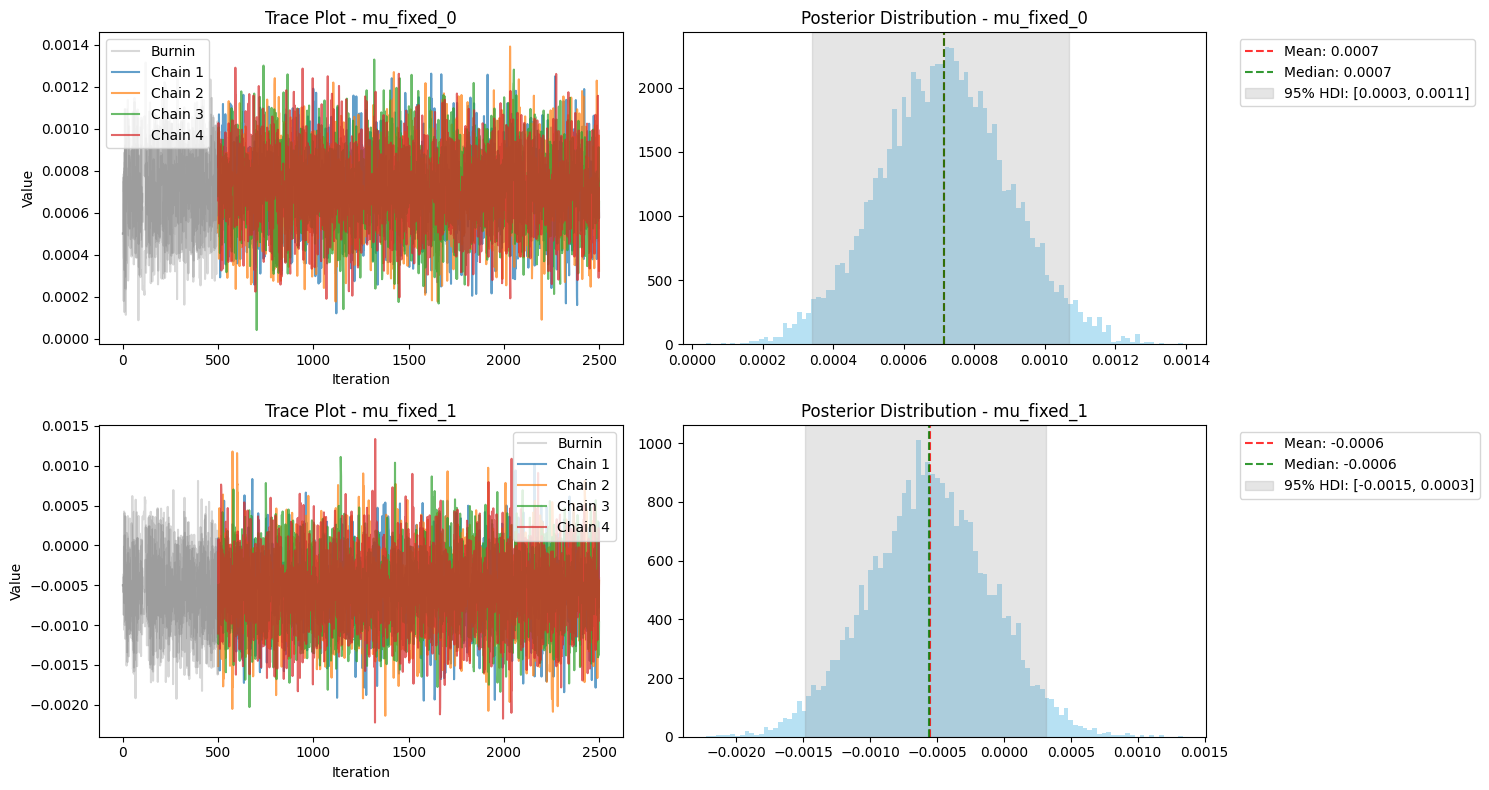

In [13]:
# Plot parameter distributions
fig = aux.plot_trace(trace, ['mu_fixed_0', 'mu_fixed_1'], burn_in=True)
if fig:
    plt.show()

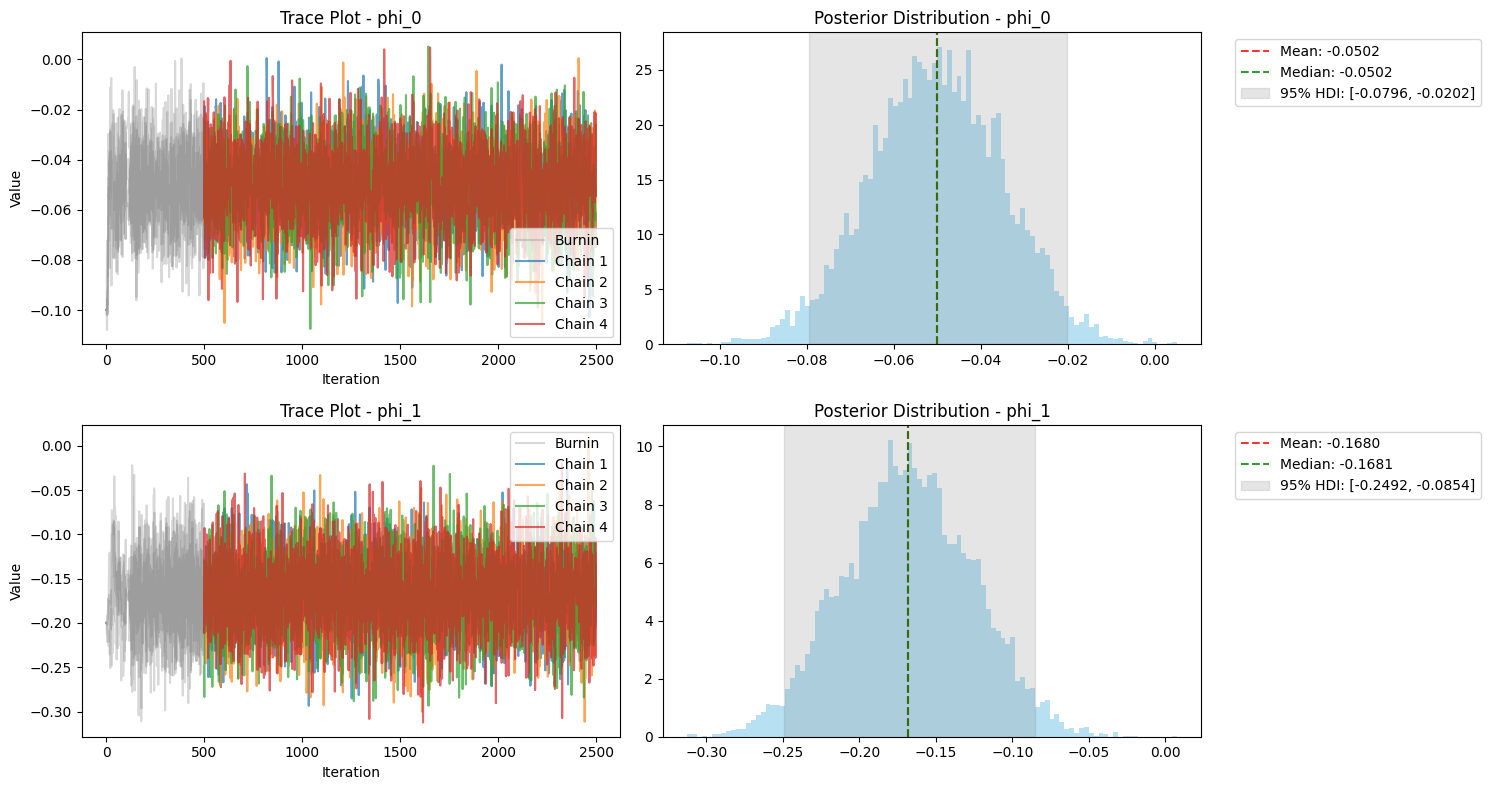

In [14]:
fig = aux.plot_trace(trace, ['phi_0', 'phi_1'], burn_in=True)
if fig:
    plt.show()

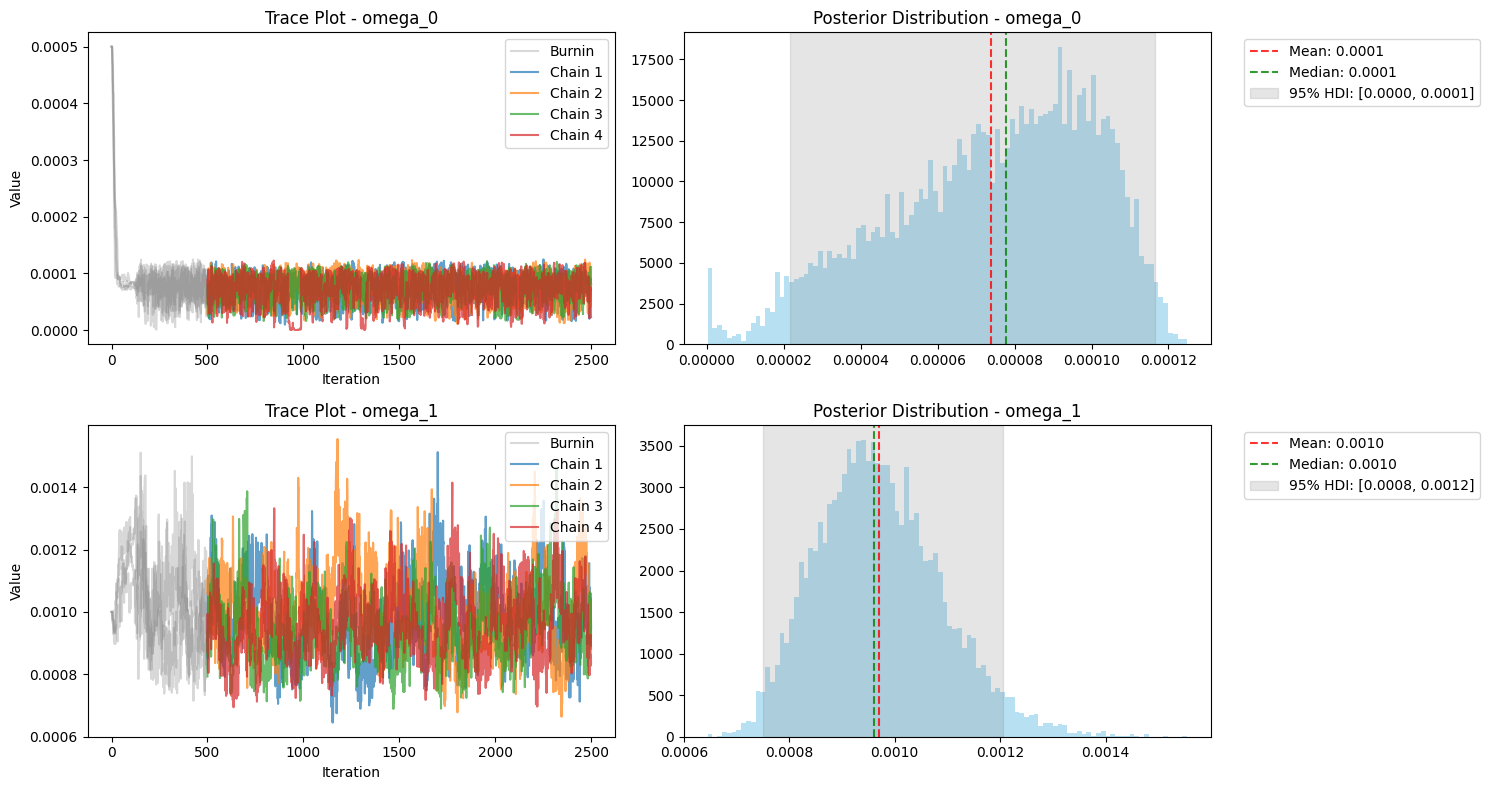

In [15]:
fig = aux.plot_trace(trace, ['omega_0', 'omega_1'], burn_in=True)
if fig:
    plt.show()

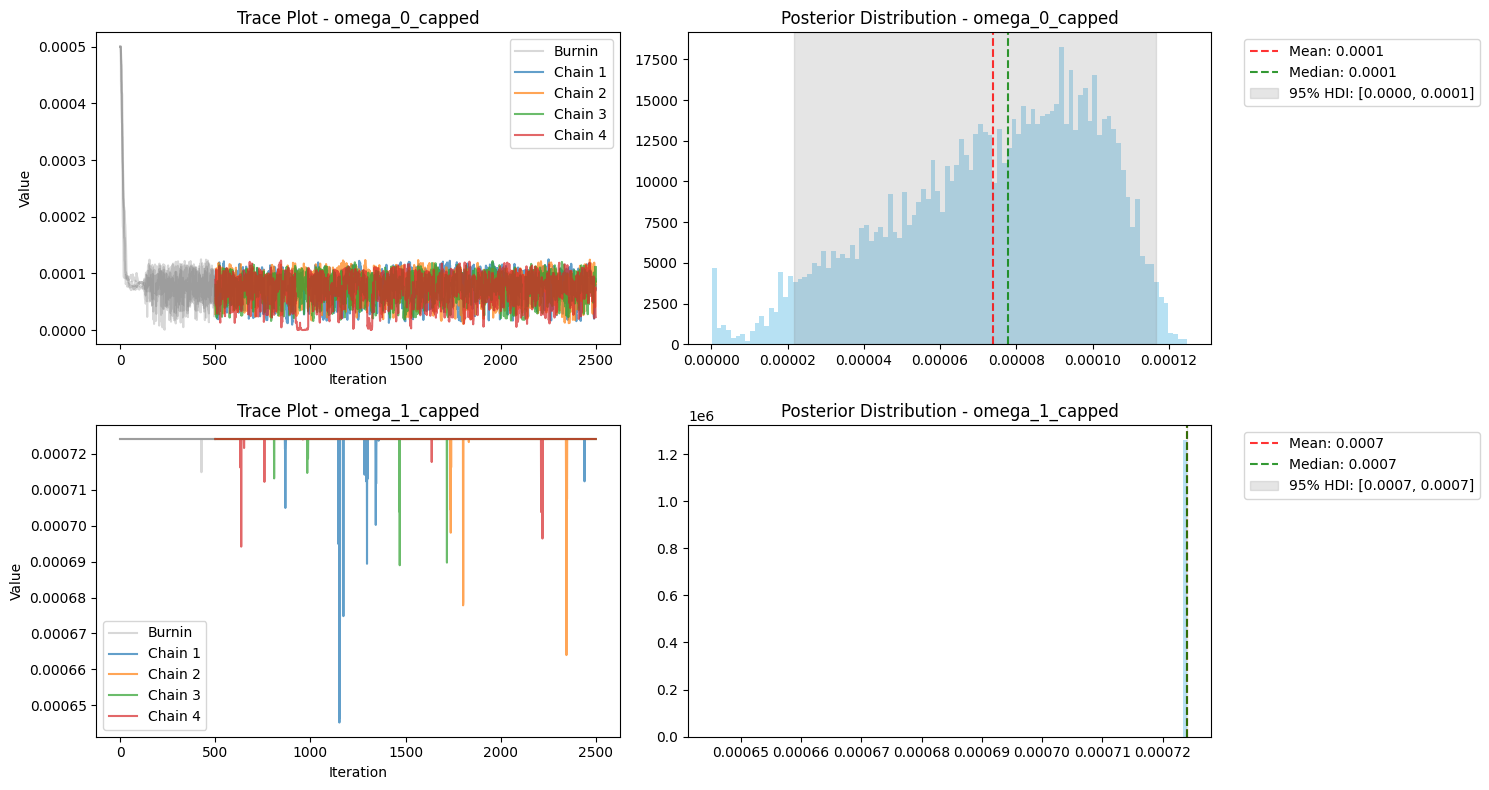

In [16]:
fig = aux.plot_trace(trace, ['omega_0_capped', 'omega_1_capped'], burn_in=True)
if fig:
    plt.show()

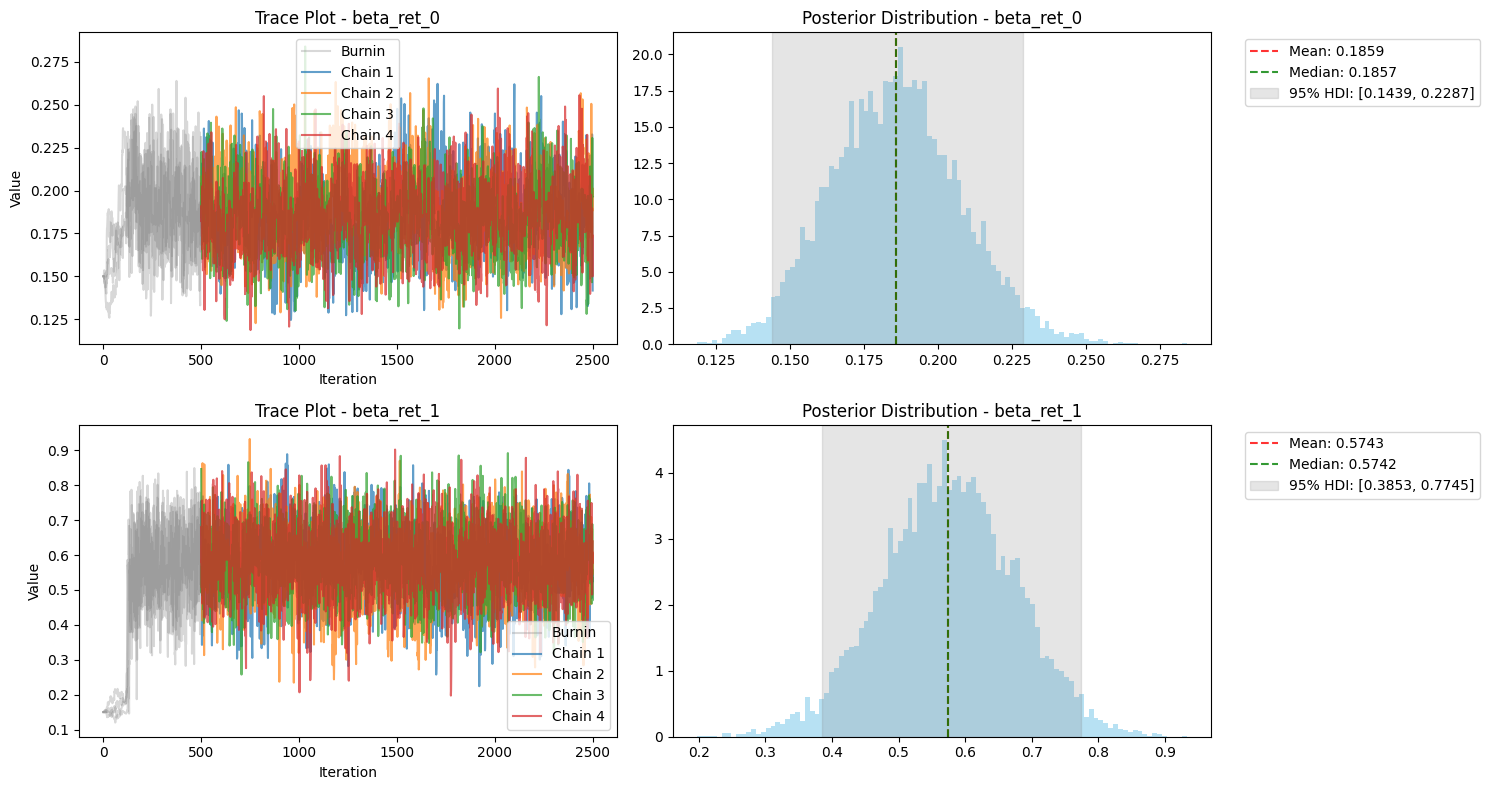

In [17]:
fig = aux.plot_trace(trace, ['beta_ret_0', 'beta_ret_1'], burn_in=True)
if fig:
    plt.show() 

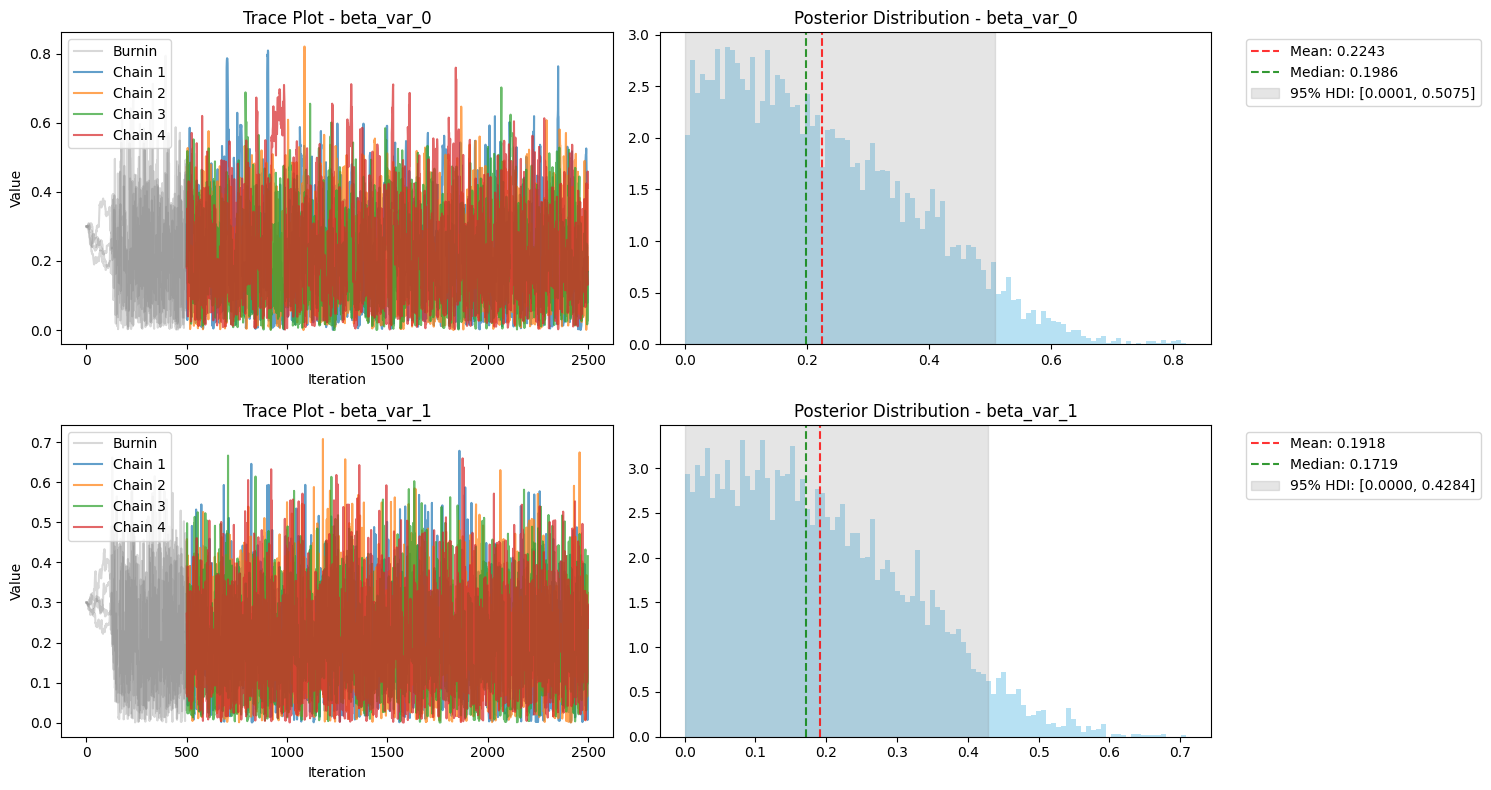

In [18]:
fig = aux.plot_trace(trace, ['beta_var_0', 'beta_var_1'], burn_in=True)
if fig:
    plt.show()

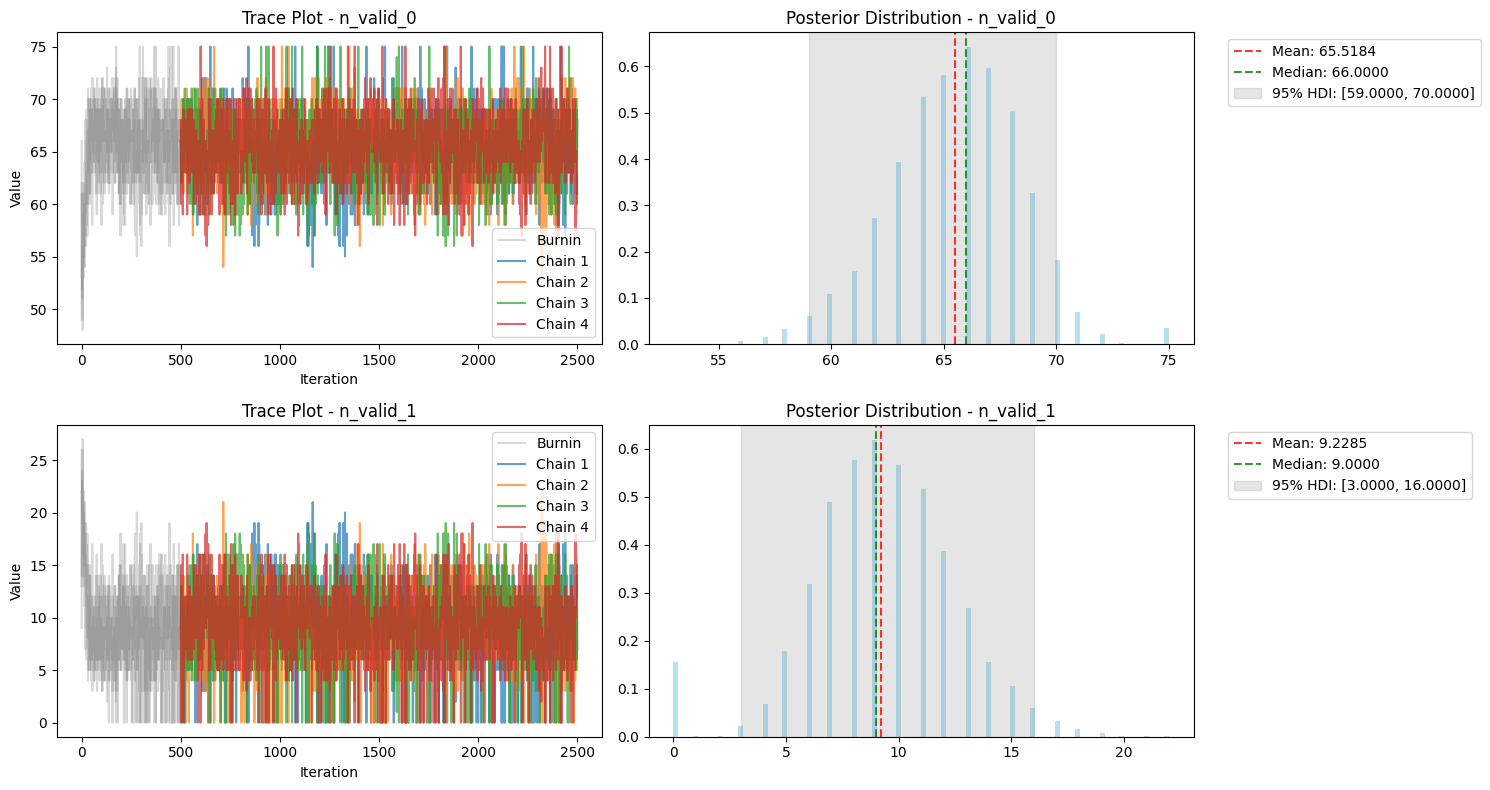

In [19]:
fig = aux.plot_trace(trace, ['n_valid_0', 'n_valid_1'], burn_in=True)
if fig:
    plt.show()

In [ ]:
fig = aux.plot_trace(trace, ['var_memory_0', 'var_memory_1'], burn_in=True)
if fig:
    plt.show()

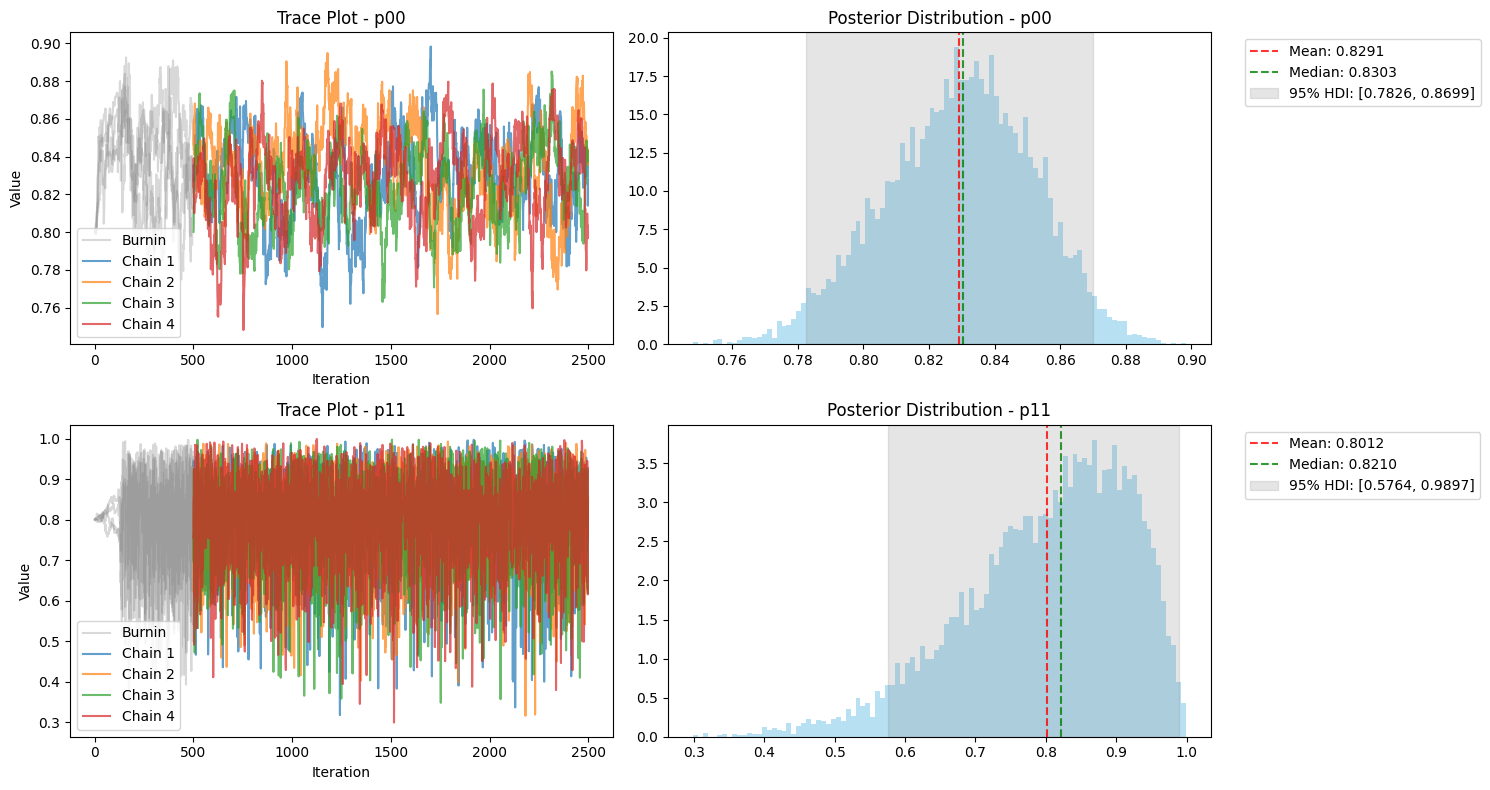

In [20]:
fig = aux.plot_trace(trace, ['p00', 'p11'], burn_in=True)
if fig:
    plt.show()

### 4.2 Model Diagnostics
 
We perform several diagnostic checks to assess model convergence and performance:
- Effective Sample Size (ESS) and R-hat statistics
- Information criteria for model comparison
- Regime persistence analysis
- Regime classification measures

In [21]:
# PERFORMING DIAGNOSTIC CHECKS (ESS, Rhat)
# We exclude the variables that are not of interest for the analysis
exclude_vars = ['beta_ret_raw_0', 'beta_ret_raw_1', 'beta_var_raw_0', 'beta_var_raw_1']     # these variables are not of interest for the analysis
diagnostic_results = aux.perform_diagnostic_checks(trace, verbose=True, exclude_vars=exclude_vars)
print(diagnostic_results)

Number of parameters: 18
Parameters: ['mu_fixed_0', 'mu_fixed_1', 'phi_0', 'phi_1', 'p00', 'p11', 'omega_0', 'omega_1', 'omega_0_capped', 'omega_1_capped', 'beta_ret_0', 'beta_var_0', 'beta_ret_1', 'beta_var_1', 'n_valid_0', 'n_valid_1', 'var_memory_0', 'var_memory_1']

Posterior Distribution Statistics:
                     mean        sd   hdi_2.5%  hdi_97.5%  mcse_mean  \
mu_fixed_0       0.000715  0.000183   0.000341   0.001068   0.000003   
mu_fixed_1      -0.000555  0.000460  -0.001484   0.000318   0.000006   
phi_0           -0.050173  0.015283  -0.079576  -0.020173   0.000230   
phi_1           -0.168016  0.042408  -0.249185  -0.085444   0.000601   
p00              0.829128  0.022665   0.782632   0.869905   0.001810   
p11              0.801155  0.118340   0.576380   0.989666   0.001330   
omega_0          0.000074  0.000027   0.000022   0.000117   0.000001   
omega_1          0.000971  0.000119   0.000751   0.001206   0.000009   
omega_0_capped   0.000074  0.000027   0.000022

In [ ]:
# Calculate information criteria
exclude_vars = [
    'beta_ret_raw_0', 'beta_ret_raw_1', 'beta_var_raw_0', 'beta_var_raw_1',  # Raw parameters used for transformation
    'n_valid_0', 'n_valid_1',       # Deterministic counts
    'var_memory_0', 'var_memory_1',     # Deterministic variance memory
    'omega_0_capped', 'omega_1_capped',  # Capped versions of omega
    'regime_probs'      # Deterministic regime probabilities
]
ic = aux.calculate_information_criteria(trace, 
                                    n_samples=len(returns), 
                                    verbose=False, 
                                    exclude_vars=exclude_vars)

for key, value in ic.items():
    print(f"{key}: {value}")

In [ ]:
# Calculate persistence results
persistence_results = aux.analyze_regime_persistence(trace, n_regimes=2)

for regime in ['regime_0', 'regime_1']:
    r = persistence_results[regime]
    print(f"\n{regime.upper()}:")
    print(f"Empirical:   mean={r['empirical']['mean']:.3f}, median={r['empirical']['median']:.3f}, std={r['empirical']['std']:.3f}")
    print(f"Expected:    mean={r['expected']['mean']:.3f}, median={r['expected']['median']:.3f}, std={r['expected']['std']:.3f}")
    print(f"Persistence Probabilities:  mean={r['transition_probs']['mean']:.3f}, median={r['transition_probs']['median']:.3f}, std={r['transition_probs']['std']:.3f}")

In [ ]:
# Calculate RCM - Regime Classification Measure
rcm_results = aux.calculate_regime_classification(trace.posterior.states, n_regimes=2)
print("Regime Classification Measure:")
for key, value in rcm_results.items():
    print(f"{key}: {value}")